## Modeling scATAC-seq data with a kNN graph (pancreatic endocrinogenesis, multiome) [Klein et al. 2023]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [4]:
import pandas as pd

In [5]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [6]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [7]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cuda:0


In [9]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [10]:
import scanpy as sc

In [11]:
# atac_path = '../../../annotations/scatac/ancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
all_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_atac.h5ad'
rna_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_rna.h5ad'
if not os.path.exists(atac_path):
    print('preparing atac...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    atac = adata[:,adata.var.modality == 'ATAC'].copy()
    print(atac.shape)
    atac.write(atac_path, compression='lzf')
if not os.path.exists(rna_path):
    print('preparing rna...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    rna = adata[:,adata.var.modality == 'GEX'].copy()
    print(rna.shape)
    rna.write(rna_path, compression='lzf')

In [12]:
atac = sc.read_h5ad(atac_path)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

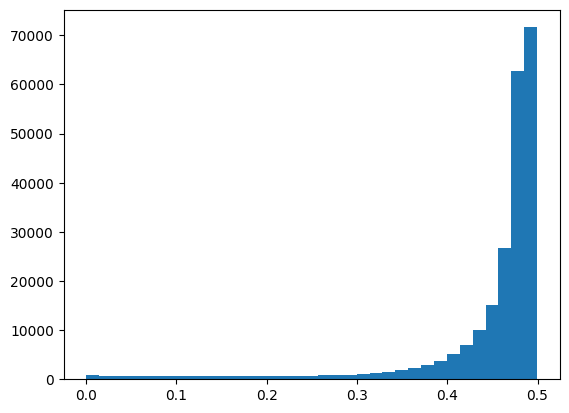

In [13]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [14]:
n_sample_cells = 1000
n_sample_peaks = int(n_sample_cells * 1.5)
obs_sample = pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(1000, 1500)

In [15]:
ad.obs['celltype'].value_counts(), ad.shape

(celltype
 Ngn3 high            220
 Ductal               170
 Imm. Acinar          109
 Prlf. Ductal          91
 Fev+                  83
 Mat. Acinar           74
 Ngn3 low              71
 Beta                  44
 Fev+ Beta             43
 Fev+ Alpha            27
 Alpha                 20
 Epsilon               11
 Fev+ Delta            11
 Eps. progenitors      10
 Ngn3 high cycling      9
 Delta                  7
 Name: count, dtype: int64,
 (1000, 1500))

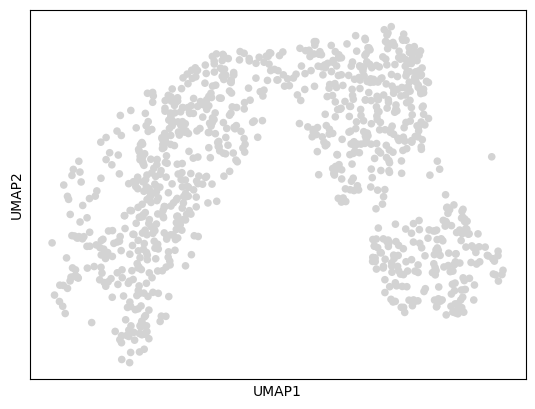

In [16]:
sc.pl.umap(ad)

In [17]:
ad.var

,modality,acc_score,acc_score_rank
1-4755780-4756640,ATAC,0.489656,33258.5
1-4802417-4803038,ATAC,0.490720,23701.5
1-14455377-14456169,ATAC,0.492316,12055.0
1-23084293-23085212,ATAC,0.406845,196057.0
1-24089851-24090475,ATAC,0.489656,33258.5
...,...,...,...
X-142467607-142468474,ATAC,0.431375,184285.5
X-146343904-146344837,ATAC,0.479194,106388.0
X-160603939-160604802,ATAC,0.486228,63753.5
X-164508463-164509514,ATAC,0.490779,23224.0


In [18]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [19]:
extend = 50

ad.var['chr'].value_counts()

chr
chr2     139
chr5     115
chr1     109
chr3      88
chr11     87
chr10     85
chr7      83
chr8      82
chr4      81
chr9      76
chr14     72
chr6      69
chr13     69
chr17     68
chr15     66
chr18     56
chr12     51
chr16     38
chr19     37
chrX      29
Name: count, dtype: int64

In [20]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [21]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpekutw4cs
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/.conda/envs/mubind/bin/bedtools', 'getfasta', '-fi', '../../../annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpekutw4cs', '-fo', '/tmp/tmpaa727tj2']
/home/ilibarra/.conda/envs/mubind/bin/bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpekutw4cs -fo /tmp/tmpaa727tj2


1500

In [22]:
len(seqs)

1500

In [24]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [25]:
counts.shape

(1500, 1000)

In [26]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [27]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [28]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(1500, 1001)

In [29]:
next_data = next_data[~next_data.index.str.contains('N')]

In [30]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [31]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [32]:
next_data.index

Index(['CCAAGGCATCCCTGGATCGTGATAGGAATGTGCTGTACAAAGTCACTTCCTGGAACACACCAGGAAGAGTGTGTTCTTGTCATGACGGATCCCAGGGTCC',
       'CCGACCTAGATGGCTCTATTGTTCTGCCACCTGCCACTGCTCTCTCCAAGACACTGCTACCCGCTGAGAAGCCCCTGAGGAGCATCCTATTCTGCAGTCG',
       'AAGAGTTACCTTCCAACACAAACTATAGACATATGAGTATACCCCATCCTTTAAGGTAAGGTAAAATGGCAGCCCATAAATGCAGGATTGTAAGGCTGCA',
       'GACATTTATTCTAGTTCCCAAGTGCGAAGAGATCGGAGCTTTTTTTAAATGTATGATCAGGTAGCTATGAATGAAGGCATAGAATTCTGCATAAATTCCT',
       'TTGCAGAACTCTCAGTAGCCTGGGATTAACACAGCACATAGAGAGCTCTTGTTTTCTTTTTGGCTTTTGGTTTTTCTTTGTAAGAAGGGAGGTCACATTT',
       'TGTTGTTATTAATTGGAACTTATTATATCTGCATGCCTTGTAATCTTTAGTAAGAAACACCTAGTGGCCATTTCCAATATGCACTGAGGATCTAATTCAG',
       'GAAAGTCCTATTTCACTCATATTCTCATATTACAAGAGTGTTTCACCTTACCCAGTTTGTACAGAGCTGAGACAGAGGCCAGGGCTTTGTGCATGGAAGT',
       'CATTTTCTCACATTTTAACATTAGCTTACTCTTTGCTGCCACCTAGCGTCCATCTCCTAACATAGCAAGAGTTAAAATGGCCTATTTGCATAAAACATGC',
       'AGCTTTTATCTCCAATGCTACAGGCACTGAGGTCACCCAGAACTTGGACTTCGAGCCAGCCCCTTGAGAGGAGCAGCAGTGTGTGCCTGGATAAACAAAC',
 

In [33]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [34]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [35]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(1500, 1000)

In [36]:
ad.shape, df.shape

((1000, 1500), (1500, 1000))

In [37]:
ad = ad[:,~zero_counts].copy()


In [38]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(1500000, 3)
1000
batch
0      1500
137    1500
127    1500
128    1500
129    1500
       ... 
69     1500
70     1500
71     1500
72     1500
199    1500
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
CGCCCGTCAGCCCTCGGGACCCCCTCCGCCCCGCCTTCAGCACCCGGCTGGTGGAAGCCACAAACTCCTTTCCCTCAGCCCCGCCTGCCTCCTCCGTCCC,1.0,0.0,0
GGCGCGCAGGGAAGGAAGAGAGGGAGGGGCGCGCGGAGGCGCGAGTCGCCCGCCCCGCACTACAGGCCACCCTTTCCACACCGCGCGCTGCAAGTTCTGA,1.0,0.0,0
TCGGGAGGAATGGGGAGCCGGGGAGAGGCTTCTAAGGGAGACTGGCTGAGGGGCGGGGCTTCTTAACGGTAGGCCGAGCCTCCACGGTAAGCGTACTGAG,1.0,1.0,0
TGGATAGTTGACCTTGCCAATTAAGGTGGGCACTGACGCCCAATGAGAAATTAAAGACTCAGAGGCGGGGCCGTGTGGGCGGGGAAAGAGAAGCACAGAA,1.0,0.0,0
TTCGGCAAGGGGATTAGCTGGTTCATTCCAGGCTGGCGGGCCGACCCGCGAGATCACGTGACACAAATCTTGACTGATGATTGGCTGTCTGAGAGAGAGG,1.0,3.0,0


### Simple motif enrichment

In [39]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [40]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [41]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [42]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [43]:
reduced_groups = pwms

In [44]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [45]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [46]:
len(pwms)

286

In [47]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

setting up log dynamic
True
12
order None
0 out of 288...
break


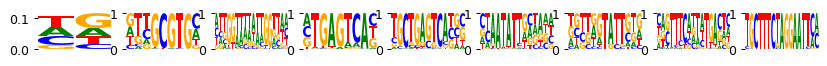

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 17%|█████████████████████████████████                                                                                                                                                              | 26/150 [02:28<18:26,  8.92s/it]

Epoch: 26, Loss: 226.393453, R2: 0.30,  best epoch: 24,  secs per epoch: 5.932 s,  secs epoch*1k trials: 3.955s curr time: 2024-04-10 20:56:05.656991


 34%|████████████████████████████████████████████████████████████████▉                                                                                                                              | 51/150 [05:34<10:46,  6.53s/it]

Epoch: 51, Loss: 191.054199, R2: 0.31,  best epoch: 49,  secs per epoch: 6.698 s,  secs epoch*1k trials: 4.465s curr time: 2024-04-10 20:59:12.243617


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 76/150 [08:22<08:01,  6.51s/it]

Epoch: 76, Loss: 174.954468, R2: 0.31,  best epoch: 74,  secs per epoch: 6.698 s,  secs epoch*1k trials: 4.466s curr time: 2024-04-10 21:01:59.740949


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 101/150 [11:18<06:33,  8.03s/it]

Epoch: 101, Loss: 166.780594, R2: 0.31,  best epoch: 99,  secs per epoch: 6.780 s,  secs epoch*1k trials: 4.520s curr time: 2024-04-10 21:04:55.396590


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 126/150 [14:24<03:47,  9.46s/it]

Epoch: 126, Loss: 162.027125, R2: 0.31,  best epoch: 124,  secs per epoch: 6.920 s,  secs epoch*1k trials: 4.613s curr time: 2024-04-10 21:08:02.312992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [17:52<00:00,  7.15s/it]


Final loss: 159.0851440430 , R2: 0.31
Total time (model/function): (1072.314s / 1072.314s)
Time per epoch (model/function): (7.197s/ 7.197s)
Time per epoch per 1k trials: 4.798s
Current time: 2024-04-10 21:11:32.543866
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:57<00:00,  7.10s/it]


Final loss: 153.9128265381 , R2: 0.31
Total time (model/function): (1249.873s / 177.559s)
Time per epoch (model/function): (52.078s/ 7.398s)
Time per epoch per 1k trials: 4.932s
Current time: 2024-04-10 21:14:33.846147


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:50<00:00,  9.23s/it]


Final loss: 147.4421844482 , R2: 0.31
Total time (model/function): (1480.755s / 230.882s)
Time per epoch (model/function): (61.698s/ 9.620s)
Time per epoch per 1k trials: 6.413s
Current time: 2024-04-10 21:18:27.632459
best loss 147.4421844482422
current r2 values by newly added filter
[0.3056693382004996]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 3 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 3 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


  0%|                                                                                                                                                                                                         | 0/25 [00:00<?, ?it/s]

In [48]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 25
log_each=25

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

    break

In [ ]:
# model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
#                                             show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
#                                             opt_kernel_shift=[0, 0] + [0] * (n_kernels),
#                                             opt_kernel_length=[0, 0] + [0] * (n_kernels),
#                                             opt_one_step=True,
#                                             shift_max=1, shift_step=1, optimiser=topti.Adam,
#                                             skip_kernels=range(0, len(model.binding_modes) - 1),
#                                             n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
#                                             kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
#                                             exp_max=8,
#                                             early_stopping=250, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

True
True
3
order None
0 out of 288...
break


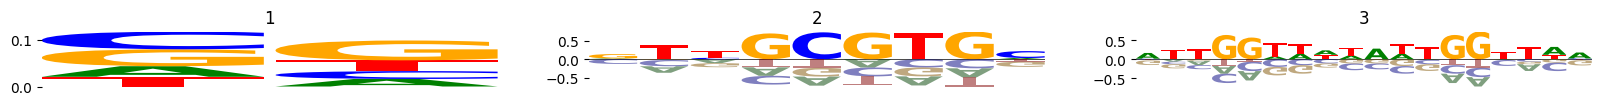

In [ ]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


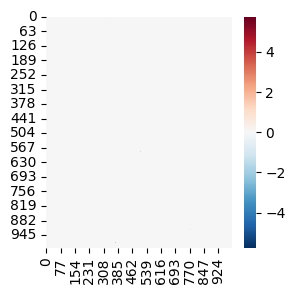

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

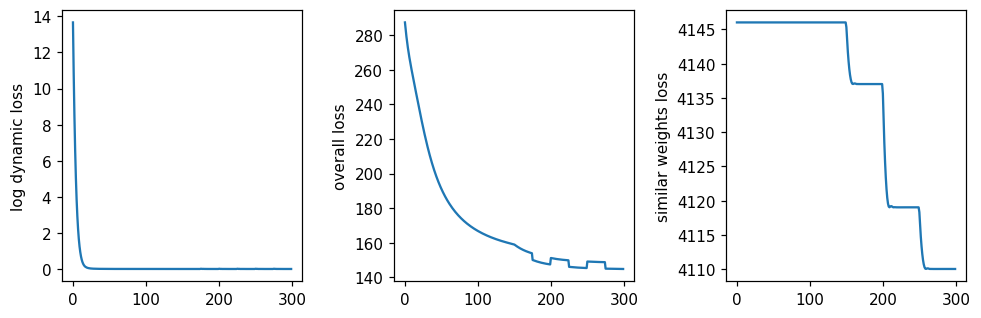

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [ ]:
model_by_logdynamic

{True: Mubind(
   (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
   (binding_modes): BindingModesSimple(
     (conv_mono): ModuleList(
       (0): None
       (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
       (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
       (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
       (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (8-9): 2 x Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
       (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
       (12): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
       (13): Conv2d(1, 1,

True


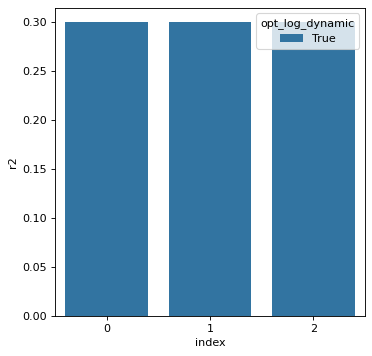

In [ ]:
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 5, 5
    rcParams['figure.dpi'] = 80
    sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic')
    plt.show()

In [ ]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [ ]:


#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
# mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
# sns.displot(dynamic_score, height=3, aspect=1.2)
# plt.xlabel('dynamic score (normalized)')


In [ ]:
ad.obs['dynamic_score'].describe()

count    1000.000000
mean        0.604541
std         0.045558
min         0.000000
25%         0.604534
50%         0.604541
75%         0.604548
max         1.000000
Name: dynamic_score, dtype: float64

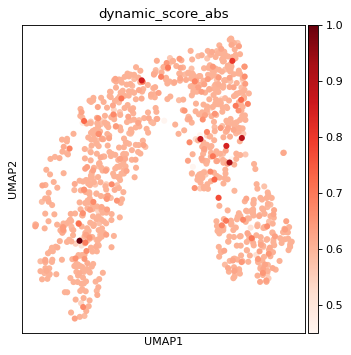

In [ ]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

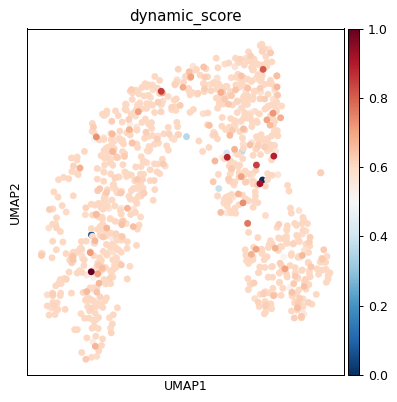

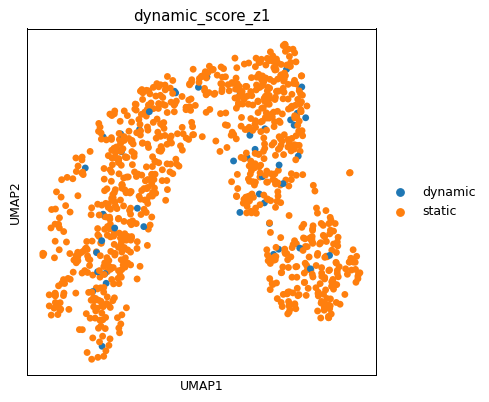

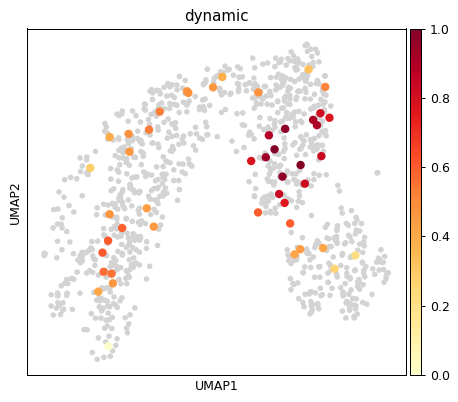

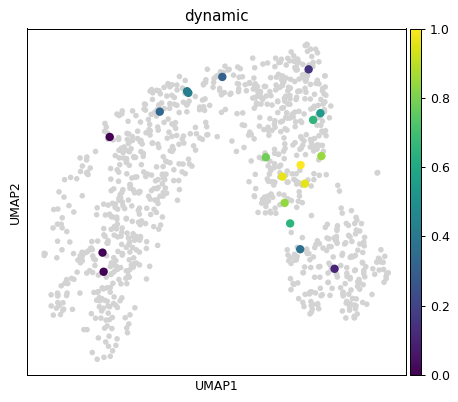

In [ ]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

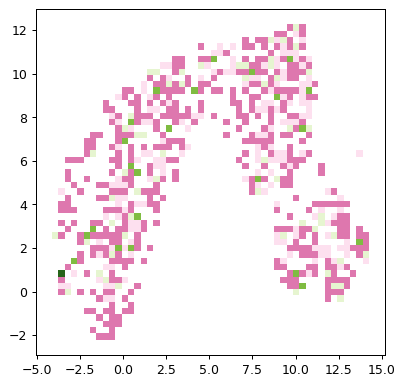

In [ ]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

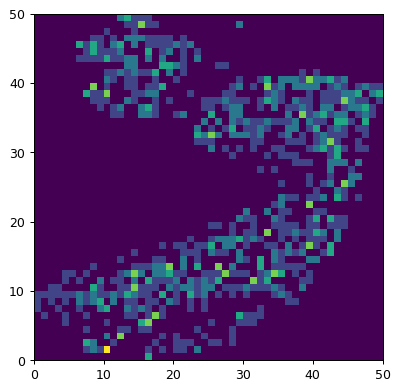

In [ ]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [ ]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [ ]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


In [ ]:
# '''
# ITB Physics Dept. / Python Programming Basics / Syeilendra
# Generate a heatmap from xyz data file
# Tested with Spyder 3.9
# '''

# from datetime import datetime
# import numpy as np
# import matplotlib.pyplot as plt

# # ***** Main Program - Begin *****

# now = datetime.now()
# localtime = now.strftime("%a %d-%m-%Y %H:%M:%S")

# print("2D Colored Heatmap")

# # Read data from text file
# array_txt = np.loadtxt("datafile1.txt",usecols=(2,3,4))
# #array_txt = np.loadtxt("datafile2.txt",usecols=(2,3,4))

# # x = array_txt[:,0]
# # y = array_txt[:,1]
# # z = array_txt[:,2]

# x = umap[:,1] # array_txt[:,0]
# y = umap[:,1] # array_txt[:,1]
# z = ad.obs['dynamic_score'].values # array_txt[:,2]

# x=np.unique(x)
# y=np.unique(y)
# X,Y = np.meshgrid(x,y)
# Z=z.reshape(len(x),len(y))
# Z=np.transpose(Z)
# data = Z
# plt.figure(figsize=(7,7), dpi=100)
# #plt.contour(X, Y, Z, 7, linewidths = 0.5, colors = 'k')
# plt.imshow( data , cmap = 'jet' , interpolation = 'gaussian' , origin='lower',\
#            aspect='equal',  extent = [min(x), max(x), min(y), max(y)] )  
# # https://matplotlib.org/stable/tutorials/colors/colormaps.html
# # https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
# plt.title( "Heatmap Sample (Syeilendra ITB)", fontsize=15 )
# plt.xlabel("X Label", fontsize=10)
# plt.ylabel("Y Label", fontsize=10)
# plt.colorbar()
# plt.show()

# print(f"Local time: {localtime}")

# # ***** Main Program - End *****

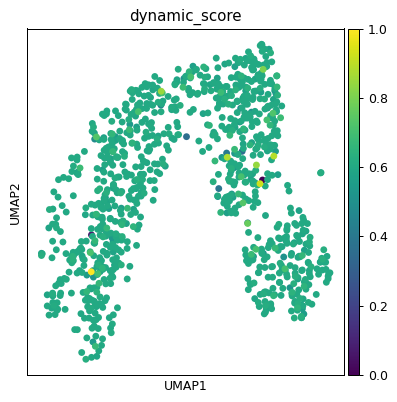

In [ ]:
sc.pl.umap(ad, color='dynamic_score')

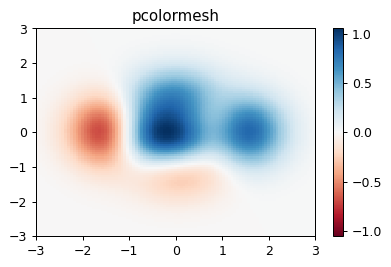

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rcParams['figure.figsize'] = 5, 3
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
# x, y = umap[:, 0], umap[:, 1]

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# z = ad.obs['dynamic_score'].values

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
# from scipy.stats import binned_statistic_2d
# import numpy as np

# # x = umap[:,0] # [0.1, 0.1, 0.1, 0.6]
# # y = umap[:,1] # [2.1, 2.6, 2.1, 2.1]

# x = [-1.1, 0.1, 0.1, 0.6]
# y = [2.1, 2.6, 2.1, 2.1]

# # x += abs(min(x))
# # y += abs(min(y))

# z = np.repeat(1, x.shape[0]) # ad.obs['dynamic_score']  # [2.,3.,5.,7.]
# binx = np.arange(np.floor(min(x)), np.ceil(max(x)), 1)
# biny = np.arange(0, 20, 1)
# # binx = np.arange(int(min(x)), int(max(x)), 1)
# # biny = np.arange(int(min(y)), int(max(y)), 1)


# print(binx, biny)

# ret = binned_statistic_2d(x, y, None, 'count', bins=[binx,biny], \
#     expand_binnumbers=True)

# print (ret.statistic)
# print (ret.binnumber)
# sums = np.zeros([-1+len(binx), -1+len(biny)])

# for i in range(len(x)):
#     m = ret.binnumber [0][i] - 1
#     n = ret.binnumber [1][i] - 1

#     # if len(sums) < m and len(sums[m]) < n:
#     # print(m, n, z[i])
#     sums[m][n] += sums[m][n] + z[i]

# print (sums)

In [ ]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [ ]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs['celltype'].cat.codes.values, size_x=1, size_y=1)

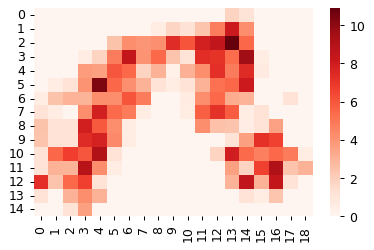

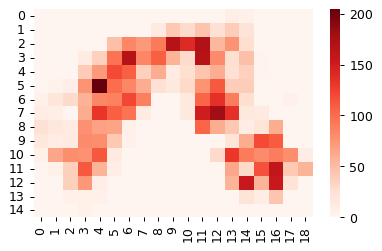

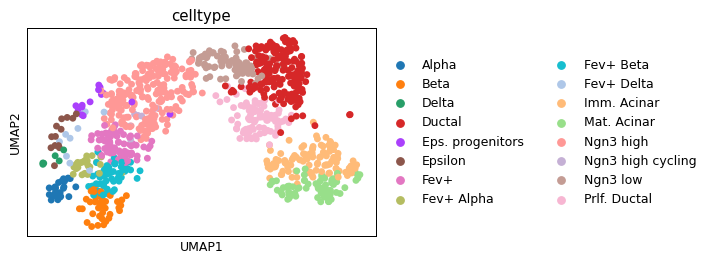

In [ ]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color='celltype')

True


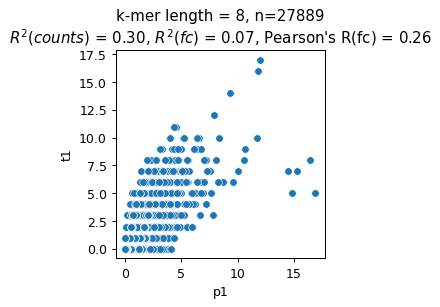

True
3
order None
0 out of 288...
10 out of 288...
break


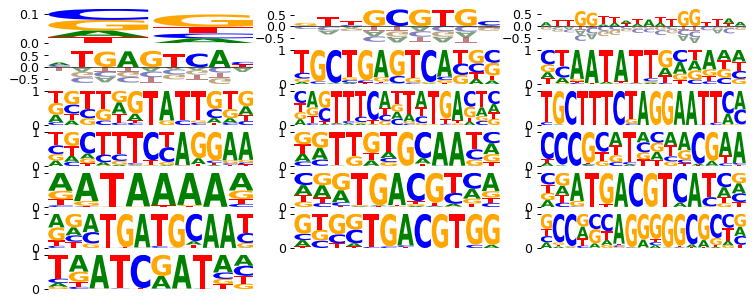

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
    plt.show()

    mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=12,
               n_cols=3,
               stop_at=20) # n_cols=len(reduced_groups))
    plt.show()


(1000, 1500)

In [ ]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)
G

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
len(G[G > 0])

1432

In [ ]:
model.binding_modes

BindingModesSimple(
  (conv_mono): ModuleList(
    (0): None
    (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
    (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
    (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
    (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
    (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
    (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (8-9): 2 x Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
    (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
    (12): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
    (13): Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)
    (14): Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
    (15): Conv2d(1, 1,

In [ ]:
output = model(**inputs, use_conn=False, return_binding_scores=True)

return binding scores...


(1000, 1500)

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

True
here...
(512, 1000)
1256843800000.0
here...
(512, 1000)
987422700000.0
here...
(476, 1000)
1163269800000.0


In [ ]:
X = ad.X.A

In [ ]:
G @ binding_scores

tensor([[ 664309.50,  676652.94,  544676.06,  ...,  912093.38,  971423.88,
          833814.56],
        [      0.00,       0.00,       0.00,  ...,       0.00,       0.00,
               0.00],
        [ 990555.88, 1007605.19,  810881.44,  ..., 1358540.00, 1442306.38,
         1243211.25],
        ...,
        [ 521859.09,  530295.81,  426346.44,  ...,  713684.06,  758137.81,
          652474.44],
        [1122788.50, 1143269.88,  920537.94,  ..., 1544786.50, 1643515.50,
         1412970.25],
        [1237043.00, 1261339.25, 1016691.25,  ..., 1711704.50, 1822221.12,
         1564783.62]])

In [ ]:
binding_scores

array([[2791909.8, 2829406. , 2271762.8, ..., 3808512.8, 4028995.5,
        3483587. ],
       [2777836.2, 2825587.5, 2273406.8, ..., 3810845. , 4052912. ,
        3485244.5],
       [2769449.5, 2828480.8, 2279191.8, ..., 3832795.5, 4112678. ,
        3501769. ],
       ...,
       [2809664.2, 2858028. , 2294359.2, ..., 3826764.5, 4094506.8,
        3495398. ],
       [2799206.8, 2847591.2, 2289639. , ..., 3837738. , 4091368.5,
        3506932. ],
       [2783313.2, 2833381.8, 2280005.8, ..., 3821409.5, 4073001. ,
        3494310.5]], dtype=float32)

In [ ]:
np.random.shuffle(binding_scores)

In [ ]:
binding_scores

array([[2772730. , 2820624.8, 2269891.5, ..., 3807904. , 4047337. ,
        3482688.8],
       [2782139. , 2830337. , 2277011.5, ..., 3817239. , 4062477. ,
        3490203.5],
       [2772656.5, 2820963. , 2270254.8, ..., 3806790. , 4048134. ,
        3481948.5],
       ...,
       [3988766.5, 3998155. , 3073986.5, ..., 5033726.5, 5859478. ,
        4387557.5],
       [2816044. , 2862790.2, 2300870.5, ..., 3871467.5, 4118509. ,
        3534272. ],
       [2767728.2, 2817459.5, 2268129.8, ..., 3803071. , 4046402.5,
        3479321.5]], dtype=float32)

computing velocity graph (using 1/16 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


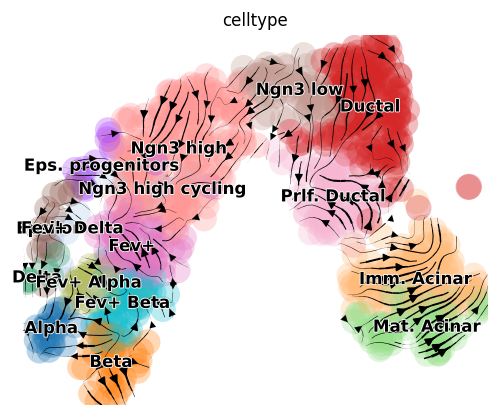

In [ ]:
ad.layers['velocity'] = binding_scores

# conn = model.graph_module.conn_sparse.detach().cpu()
# conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
# v = conn.sum(axis=1)
# ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()

# ad.layers['counts'] = ad.X

# mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
# plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
# plt.show()

# import scvelo as scv

# sc.pp.neighbors(ad)

# # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# # ad.layers['velocity'] = ad.obs['dynamic_score']

scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [ ]:
np.random.shuffle(binding_scores)
binding_scores

array([[2215183.5, 2031707.6, 2313319.5, ..., 2561362.5, 2537347.2,
        2358367.2],
       [2206027.5, 2024644. , 2303504.5, ..., 2548948. , 2525136. ,
        2346163. ],
       [2210709.5, 2026137. , 2310391.5, ..., 2533411.2, 2512909.8,
        2331864.8],
       ...,
       [2229563. , 2041407.5, 2329733.5, ..., 2563549.5, 2540286.2,
        2361245. ],
       [2184008.5, 2005758. , 2281976.2, ..., 2511973.5, 2489249.8,
        2311969.5],
       [2219892.5, 2034110.8, 2319390. , ..., 2555162.2, 2532233.5,
        2353241.8]], dtype=float32)

computing velocity graph (using 1/16 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


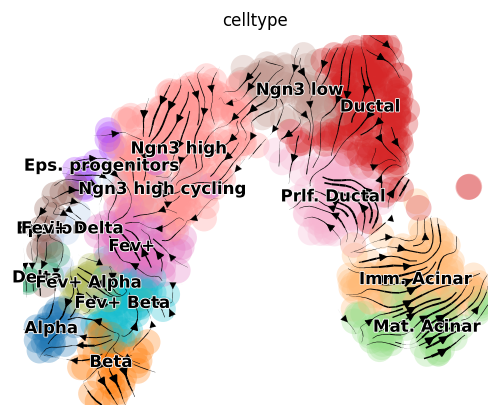

In [ ]:
np.random.shuffle(binding_scores)
ad.layers['velocity'] = binding_scores
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

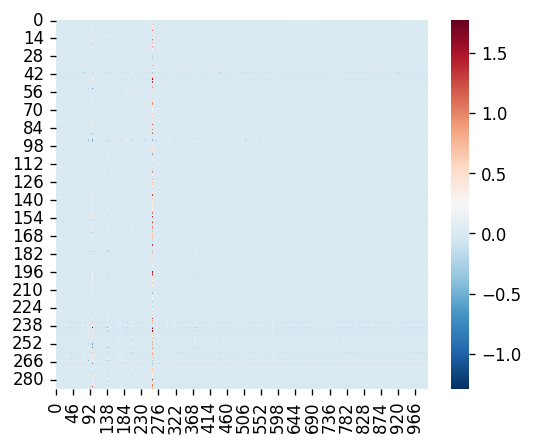

In [ ]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r
            ')

AnnData object with n_obs × n_vars = 1000 × 1500
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2', 'velocity_self_transition'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_uma

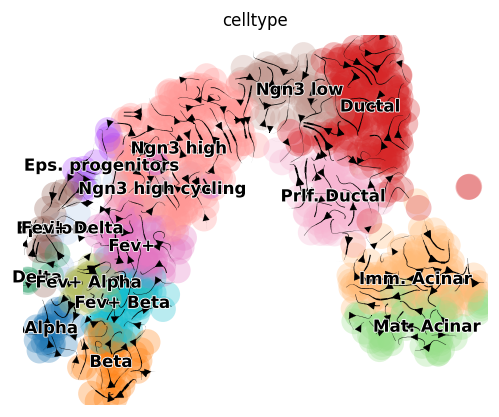

In [ ]:

ax = scv.pl.velocity_embedding_stream(ad,
                                      color='celltype',
                                      # density=2,
                                      arrow_color='black',
                                      n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

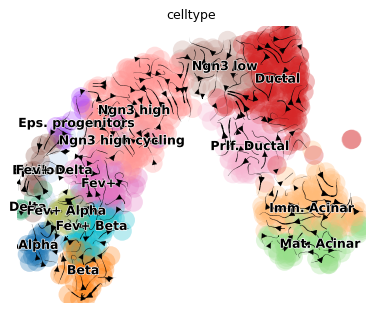

In [ ]:
ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [ ]:
print('here...')

here...


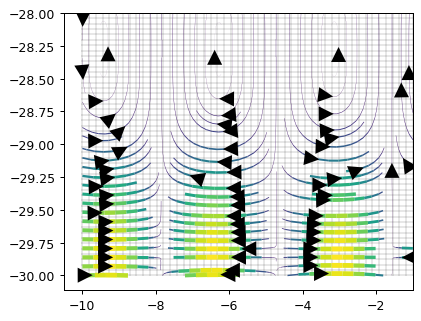

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10,-1, 50)
y = np.linspace(-30, -28, 50)

xi, yi = np.meshgrid(x,y)

u =  3*np.cos(xi)*((-3)*np.sin(yi))**3
v = 2*np.sin(xi)*3*np.cos(yi)
speed = np.sqrt((u**2)+(v**2))

lw = 4*speed/speed.max()

plt.ion()
plt.figure()
plt.plot(xi,yi,'-k',alpha=0.1)
plt.plot(xi.T,yi.T,'-k',alpha=0.1)
c = plt.streamplot(xi,yi,u,v,linewidth=lw,color=speed)

import matplotlib.patches

# get the axes (note that you should actually capture this when creating the subplot)
ax = plt.gca()

# iterate through the children of ax
for art in ax.get_children():
    # we are only interested in FancyArrowPatches
    if not isinstance(art, matplotlib.patches.FancyArrowPatch):
        continue
    # remove the edge, fill with black
    art.set_edgecolor([0, 0, 0, 0])
    art.set_facecolor([0, 0, 0, 1])
    # make it bigger
    art.set_mutation_scale(30)
    # move the arrow head to the front
    art.set_zorder(10)

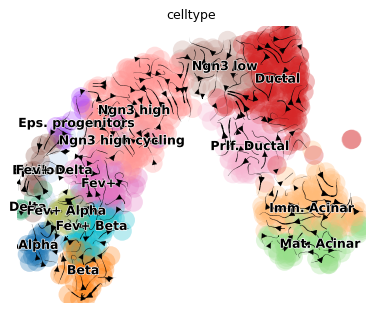

In [ ]:
scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

In [ ]:
rna = sc.read_h5ad(rna_path)
rna.shape
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape
anno = mb.datasets.archetypes_anno()

In [ ]:
rna_sel.shape

(1000, 14663)

True


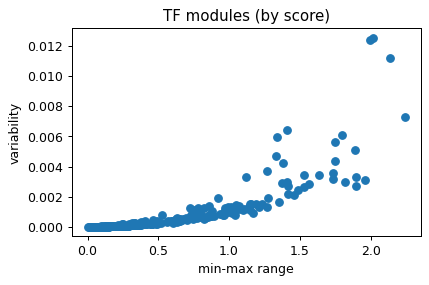

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

In [ ]:
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


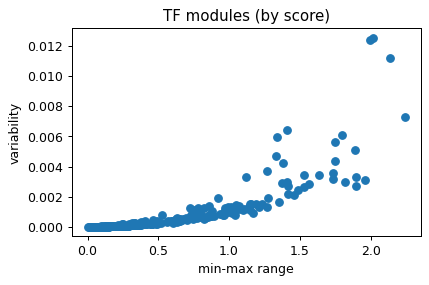

In [ ]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])


In [ ]:
res.sort_values('spearman', ascending=False)

,opt_log_dynamic,archetype_id,spearman,p_val
259,True,258,0.102863,0.001124
3,True,2,0.101785,0.001268
214,True,213,0.095893,0.002400
177,True,176,0.087666,0.005535
0,True,intercept,0.086604,0.006137
...,...,...,...,...
200,True,199,-0.045956,0.146447
199,True,198,-0.051906,0.100909
258,True,257,-0.060003,0.057856
63,True,62,-0.060199,0.057040


In [ ]:
res = pd.DataFrame(pd.concat([delta, var], axis=1))
res['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
res['archetypes_name'] = res['name'].map(anno.set_index('Cluster_ID')['Name'])
res['archetypes_seed'] = res['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
res = res.sort_values(0, ascending=0)
res

,0,1,name,archetypes_name,archetypes_seed
92,2.240767,7.297182e-03,92,SOX/3,SOX10_HMG_4
238,2.133948,1.120162e-02,238,PROX1,PROX1_MA0794.1
40,2.015678,1.254256e-02,40,NR/11,ERR2_MOUSE.H11MO.0.A
266,1.996962,1.240762e-02,266,INSM1,INSM1_HUMAN.H11MO.0.C
197,1.958033,3.133713e-03,197,ZNF586,ZN586_HUMAN.H11MO.0.C
...,...,...,...,...,...
1,0.022426,4.621574e-07,1,HD/1,LHX6_homeodomain_3
158,0.020998,1.013655e-06,158,E2F/4,E2F2_HUMAN.H11MO.0.B
114,0.019424,4.578877e-07,114,MZF1,MZF1_HUMAN.H11MO.0.B
dinuc_bias,0.011570,1.343721e-07,dinuc_bias,NaN,NaN


<Axes: xlabel='0', ylabel='archetypes_name'>

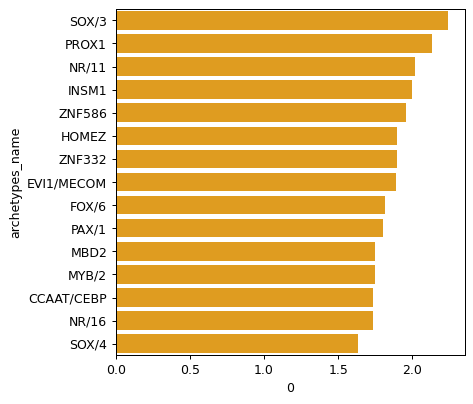

In [ ]:
rcParams['figure.figsize'] = 5, 5
sns.barplot(data=res.head(15), x=0, y='archetypes_name', color='orange')

In [ ]:
res.head(20)

,0,1,name,archetypes_name,archetypes_seed
92,2.240767,0.007297,92,SOX/3,SOX10_HMG_4
238,2.133948,0.011202,238,PROX1,PROX1_MA0794.1
40,2.015678,0.012543,40,NR/11,ERR2_MOUSE.H11MO.0.A
266,1.996962,0.012408,266,INSM1,INSM1_HUMAN.H11MO.0.C
197,1.958033,0.003134,197,ZNF586,ZN586_HUMAN.H11MO.0.C
195,1.898823,0.003283,195,HOMEZ,HOMEZ_HOMEZ_1
152,1.895684,0.002701,152,ZNF332,ZN322_HUMAN.H11MO.0.B
241,1.888398,0.005106,241,EVI1/MECOM,EVI1_HUMAN.H11MO.0.B
87,1.818653,0.002971,87,FOX/6,FOXB1_forkhead_2
281,1.800020,0.006076,281,PAX/1,PAX1_MA0779.1


True
1
order None
0 out of 288...
10 out of 288...
break


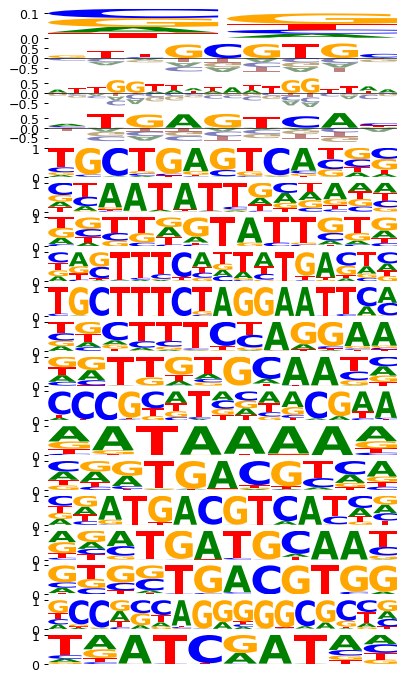

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([ 92, 238,  40, 266, 197, 195, 152, 241,  87, 281, 239, 254,  52,  45,
        93, 279,  44, 251, 179, 174],
      dtype='object')
0 out of 288...
10 out of 288...


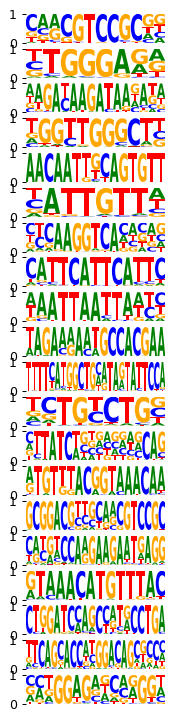

<Figure size 180x1800 with 0 Axes>

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 9.231172


In [ ]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [ ]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [ ]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [ ]:
from scipy.stats import spearmanr

In [ ]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')

res = []
print(len(all_targets))
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 10 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel.X[:,rna_sel.var_names == t]
            assert gex.shape[1] == 1
            gex = gex.A.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

True
3828
True
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


In [ ]:
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())

In [ ]:
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj


In [ ]:
res

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
0,True,2,Isl1,True,-0.047252,0.135386,HD/2,0.879924
1,True,2,Gen1,True,0.027024,0.393296,HD/2,0.935144
2,True,2,Pax4,True,0.016289,0.606914,HD/2,0.970401
3,True,2,Mnx1,True,0.019239,0.543397,HD/2,0.962173
4,True,2,Tsen15,True,0.017616,0.577919,HD/2,0.962946
...,...,...,...,...,...,...,...,...
4392,True,281,Pax2,True,0.057506,0.069107,PAX/1,0.845494
4393,True,281,Pax6,True,-0.029126,0.357531,PAX/1,0.926647
4394,True,283,Pax2,True,0.057506,0.069107,PAX-halfsite,0.845494
4395,True,284,Ahr,True,-0.018589,0.557094,AHR,0.962173


In [ ]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')


In [ ]:
res.pivot(index='k', columns='opt_log_dynamic', values='matched')

opt_log_dynamic,True
k,
A3galt2_70,True
Aar2_248,True
Aard_248,True
Aars2_248,True
Aars_248,True
...,...
mt-Nd3_70,True
mt-Nd4_70,True
mt-Nd4l_70,True


In [ ]:
df2['matched'] = res.pivot(index='k', columns='opt_log_dynamic', values='matched')[True]

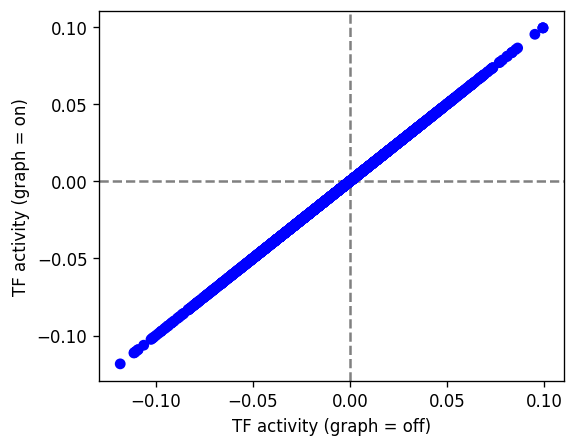

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
df2 = df2.sort_values('matched', ascending=True)
plt.scatter(df2[True], df2[True],
            color=np.where(df2['matched'], 'blue', 'gray'),
            s=np.where(df2['matched'], 30, 5))
plt.xlabel('TF activity (graph = off)')
plt.ylabel('TF activity (graph = on)')
plt.axhline(0, color='gray', ls='--', zorder=0)
plt.axvline(0, color='gray', ls='--', zorder=0)


In [ ]:
df2[df2['matched'] == True].sort_values(True, ascending=False)

opt_log_dynamic,True,matched
k,,
Pparg_248,0.099312,True
Pparg_32,0.099312,True
Pparg_46,0.099312,True
mt-Co3_70,0.095160,True
Tspan12_70,0.086279,True
...,...,...
Tlk2_70,-0.110251,True
Rhot1_70,-0.110827,True
Rmst_70,-0.111110,True


True


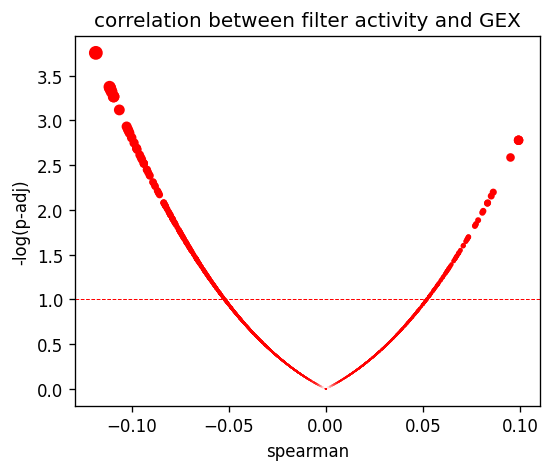

In [ ]:
for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    print(optimize_log_dynamic)
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 3), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('correlation between filter activity and GEX')
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

In [ ]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

In [ ]:
res[res['p_val'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
12,True,2,Psen2,True,-0.060164,0.057186,HD/2,0.816544,Psen2_2
16,True,2,Nkx6-2,True,0.062389,0.048568,HD/2,0.808784,Nkx6-2_2
21,True,2,Tsen2,True,0.083264,0.008430,HD/2,0.718826,Tsen2_2
32,True,2,Abraxas1,True,0.065952,0.037048,HD/2,0.775720,Abraxas1_2
44,True,10,Hnf1b,True,-0.070107,0.026628,HD/10,0.775720,Hnf1b_10
...,...,...,...,...,...,...,...,...,...
4358,True,257,Zfp53,True,0.053070,0.093482,P53-like/1,0.856269,Zfp53_257
4369,True,261,Glis1,True,0.059285,0.060920,GLIS,0.829750,Glis1_261
4382,True,264,Ap2a2,True,-0.118369,0.000176,TFAP2/1,0.340351,Ap2a2_264
4392,True,281,Pax2,True,0.057506,0.069107,PAX/1,0.845494,Pax2_281


In [ ]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [ ]:
# sc.pl.umap(rna_sel, color=sel_genes,
#            cmap='Reds', ncols=3)


In [ ]:
import anndata
ad_act = anndata.AnnData(ad.obsm['log_activities'])
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

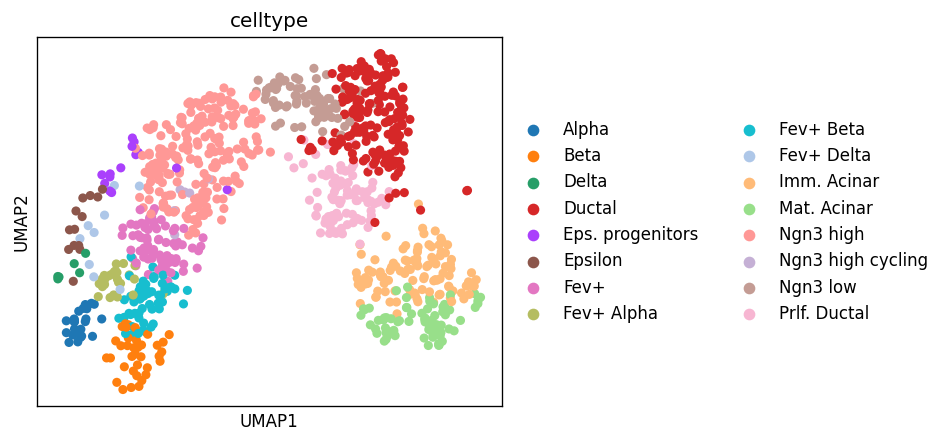

In [ ]:
sc.pl.umap(ad_act, color='celltype')


Rank genes groups using the annotation

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
rkg_df = []
for ct in ad_act.obs['celltype'].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2['celltype'] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Fev+
Imm. Acinar
Fev+ Beta
Prlf. Ductal
Ngn3 high
Eps. progenitors
Ngn3 low
Ductal
Alpha
Fev+ Alpha
Fev+ Delta
Beta
Delta
Epsilon
Ngn3 high cycling
Mat. Acinar


,names,scores,logfoldchanges,pvals,pvals_adj,celltype,module_name
0,234,0.902213,NaN,0.369763,0.698411,Fev+,234
1,175,0.887590,2.886426,0.377581,0.698411,Fev+,175
2,31,0.884182,0.722297,0.376919,0.698411,Fev+,31
3,195,0.837134,NaN,0.405065,0.717912,Fev+,195
4,238,0.815456,-0.486590,0.417113,0.717912,Fev+,238


Get top modules

In [ ]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

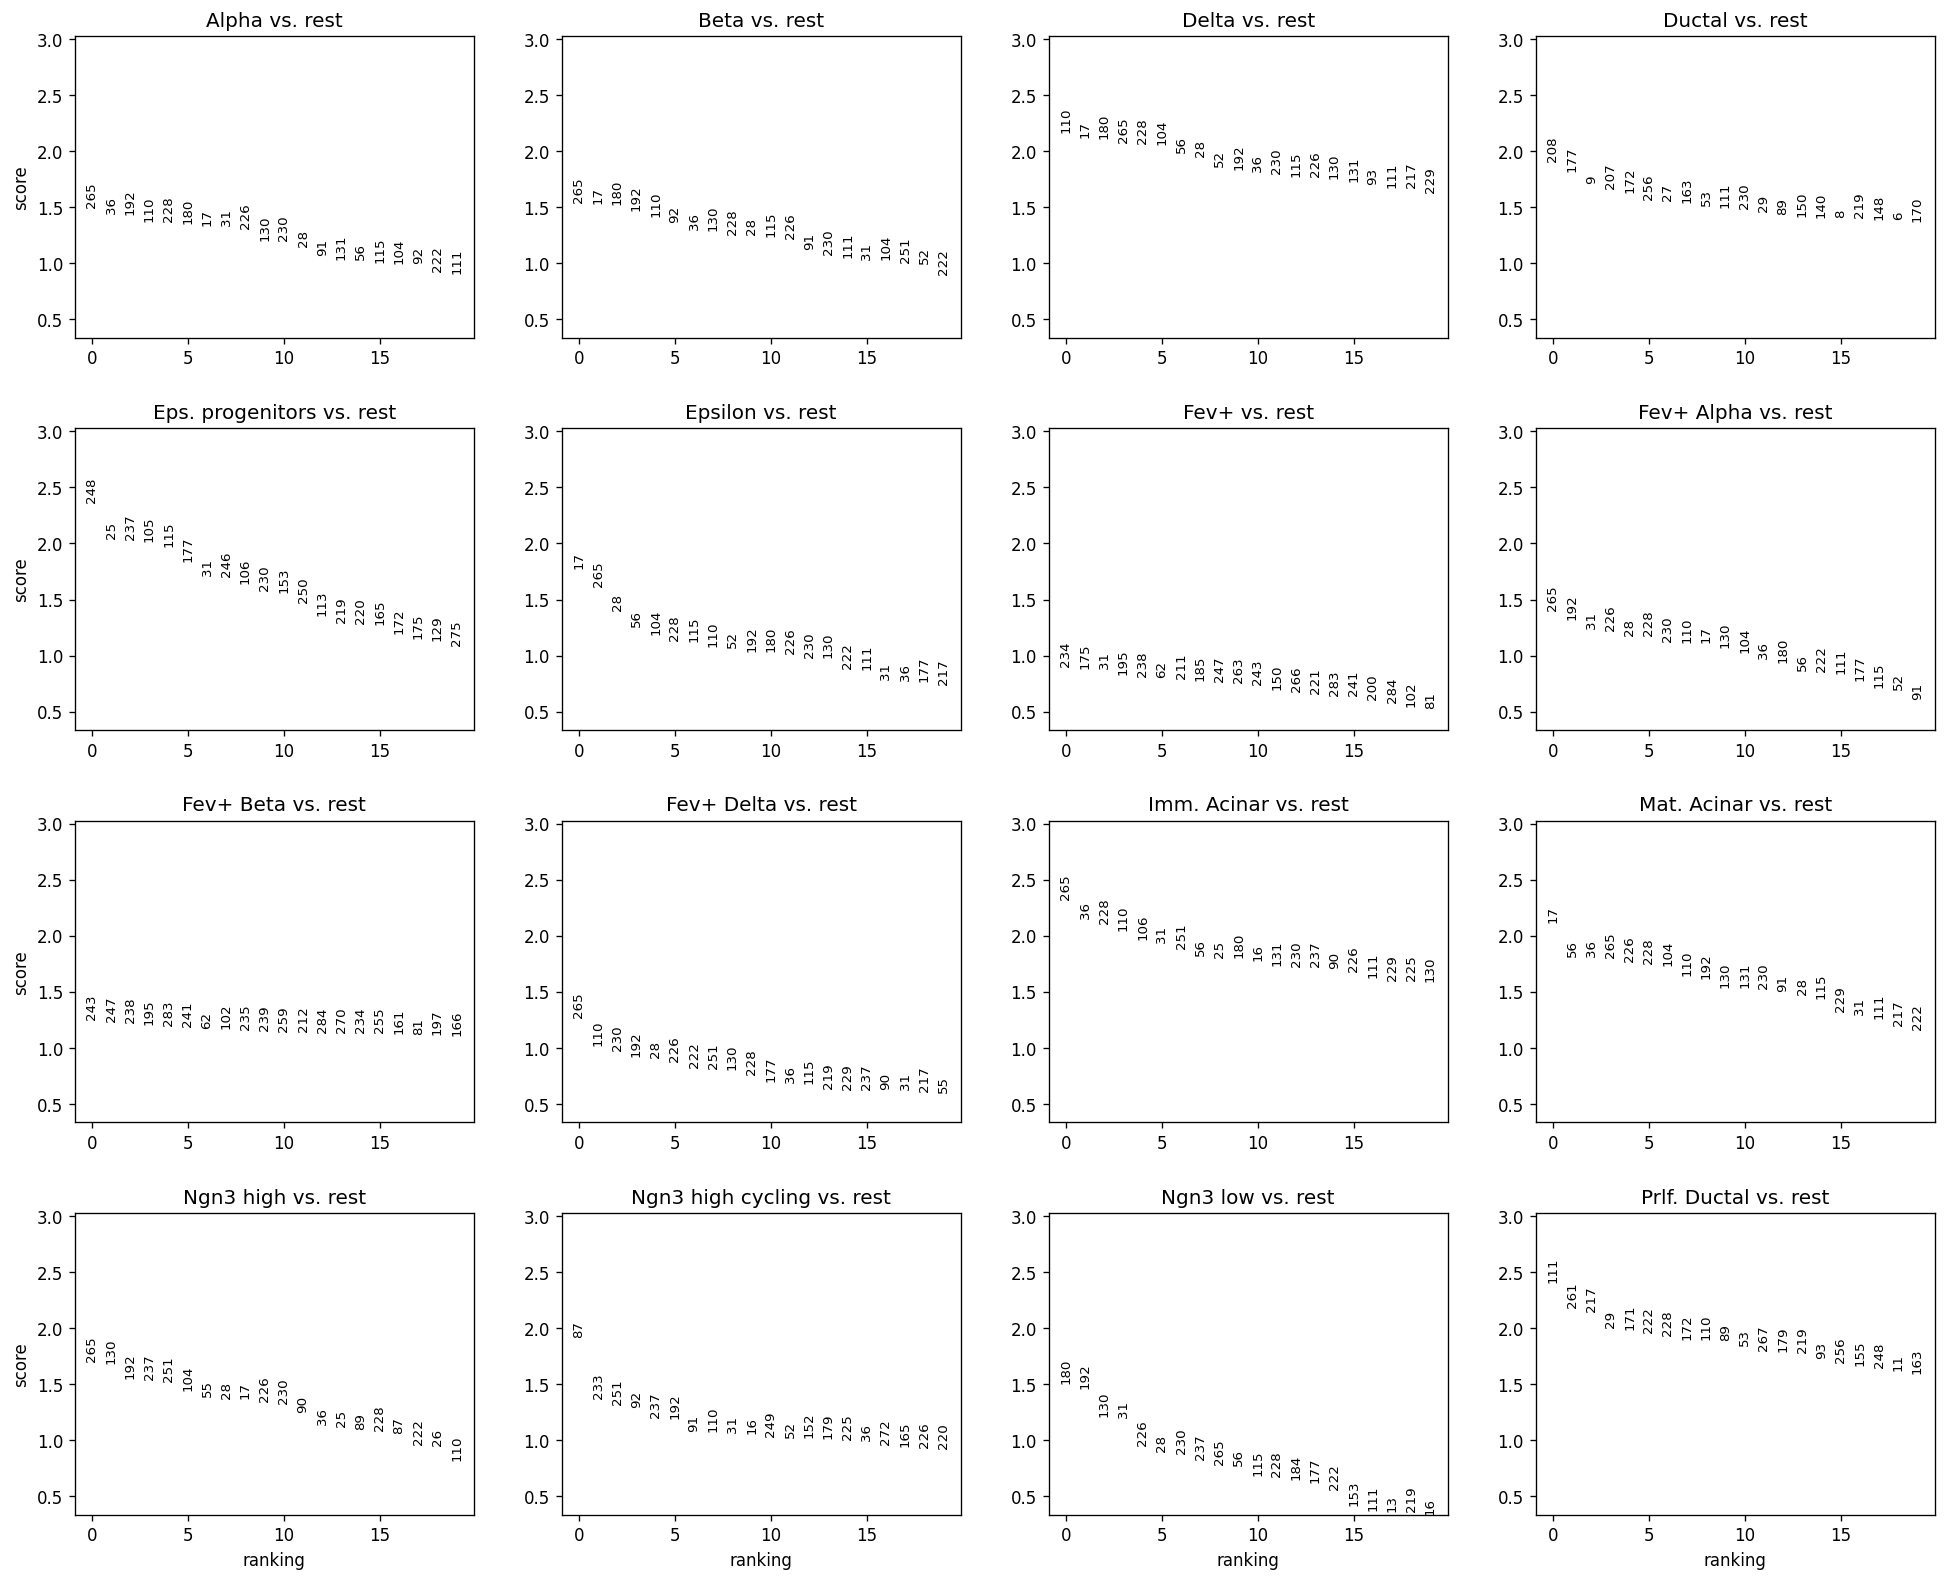

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
sc.pl.rank_genes_groups(ad_act)


In [ ]:
len(set(res[(res['p_adj'] < 1e-5)]['k']))

0

In [ ]:
set(res[(res['p_adj'] < 1e-5)]['k'])

set()

In [ ]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
21,True,2,Tsen2,True,0.083264,0.008430,HD/2,0.718826,Tsen2_2
44,True,10,Hnf1b,True,-0.070107,0.026628,HD/10,0.775720,Hnf1b_10
32,True,2,Abraxas1,True,0.065952,0.037048,HD/2,0.775720,Abraxas1_2
16,True,2,Nkx6-2,True,0.062389,0.048568,HD/2,0.808784,Nkx6-2_2
12,True,2,Psen2,True,-0.060164,0.057186,HD/2,0.816544,Psen2_2
0,True,2,Isl1,True,-0.047252,0.135386,HD/2,0.879924,Isl1_2
70,True,24,Arid3a,True,0.047469,0.133593,HD/18,0.879924,Arid3a_24
11,True,2,Shox2,True,0.043002,0.174218,HD/2,0.888295,Shox2_2
6,True,2,Pou6f2,True,-0.041588,0.188833,HD/2,0.888328,Pou6f2_2
3898,True,204,Irx2,True,-0.041239,0.192566,HD/23,0.897167,Irx2_204


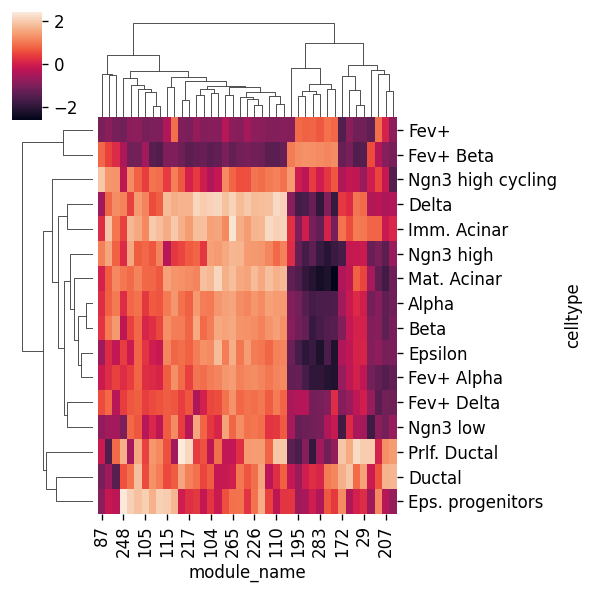

In [ ]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby('celltype').head(5)['module_name'])
sns.clustermap(rkg_df[rkg_df['module_name'].isin(mod_names_best)].pivot(index='celltype', columns='module_name', values='scores'), figsize=[5, 5])


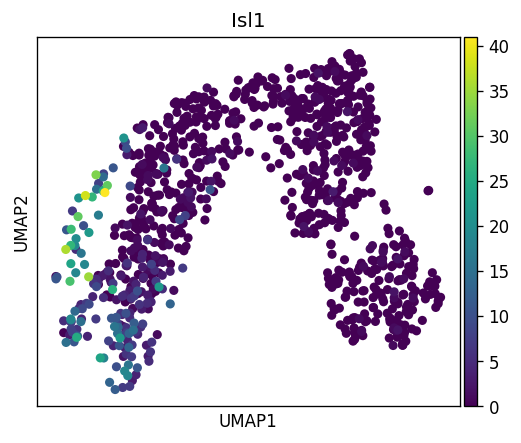

In [ ]:
sc.pl.umap(rna_sel, color='Isl1')


In [ ]:
# rna_sel['Ehf']

In [ ]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

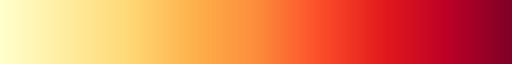

In [ ]:
cmap

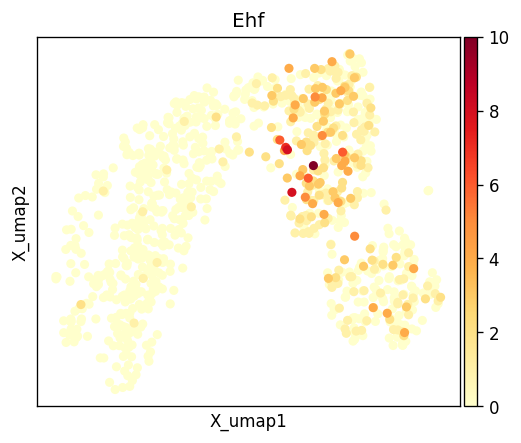

In [ ]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)
